# Propagation on Dendritic Tree

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

# Protocol Description

- single synaptic stimulation at all points of the dendritic tree

### Example Simulation
Run the below example with:
```
python propagation.py --test -c Basket --with_active --nmax 10
```

(0.0, 1000.0)

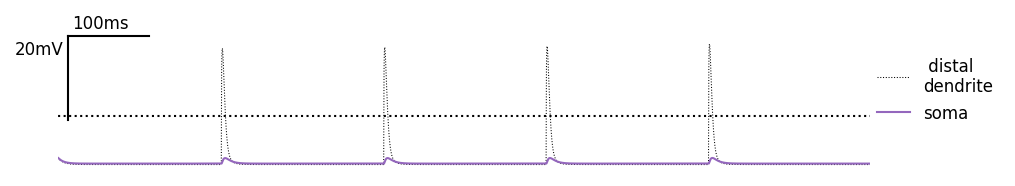

In [84]:
results = np.load('single_sim.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, ax = pt.figure(figsize=(2.5,1.5), left=0, bottom=0., hspace=0.)
ax.plot(t, results['Vm_dend'], 'k:', lw=0.5, label=' distal\ndendrite')
ax.plot(t, results['Vm_soma'], 'tab:purple', label='soma')
ax.plot(t, -60+0*t, 'k:')
pt.draw_bar_scales(ax, Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
ax.legend(frameon=False, loc=(1, 0.3))
ax.axis('off')
ax.set_xlim([0,1000])

### Functions to Load and Analyze the Simulation Data

In [75]:
def load_params_from(sim):
    p = {}
    for k, t in zip(['dt', 'ISI', 't0', 'nCluster'], [float, float, float, int]):
        p[k] = sim.fetch_quantity_on_grid(k, dtype=t, return_last=True) 
    p['synapses'] = sim.fetch_quantity_on_grid('synapses', dtype=object, return_last=True)
    return p

def extract_trials(sim, 
                  loc='soma',
                  varied_key = 'with_NMDA',
                  true_false_labels=['with-NMDA', 'without'],
                  pre=-30, post=150):
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    nBranch = len(np.unique(sim.iBranch))
    VMs = {}
    
    for l, label in enumerate(true_false_labels):
        VMs[label] = [None for iBranch in np.unique(sim.iBranch)]
        
        for iBranch in np.unique(sim.iBranch):
            
            params = {varied_key:(label==true_false_labels[0]),
                      'iBranch':iBranch}

            Vm = sim.get('Vm_%s' % loc, params)[0]
            synapses = sim.get('synapses', params)[0]
            
            _, VMs[label][iBranch] = \
                    trial_alignement(Vm, p, synapses,
                                     pre=pre, post=post)
            
    return T, VMs
    
def trial_alignement(Vm, p, synapses,
                     spike_threshold=-20,
                     pre=-30, post=150):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((len(synapses), len(T)))
    for r in range(len(synapses)):
        tstart = p['t0']+r*p['ISI']
        cond = (t>=(tstart+T[0]))
        VMs[r,:] = Vm[cond][:len(T)]
            
    return T, VMs

# Basket Cell

### Simulation

```
python propagation.py -c Basket --nCluster 1 --test_active --suffix Single
python propagation.py -c Basket --nCluster 4 --test_active --suffix Multi
```

In [76]:
sim = Parallel(\
        filename='../../data/detailed_model/Propagation_simSingle_Basket.zip')
sim.load()

T, VMs = extract_trials(sim,
                        loc='soma',
                        varied_key = 'passive_only',
                        true_false_labels=['without', 'with-Acurrent'],
                        pre=-10, post=100)

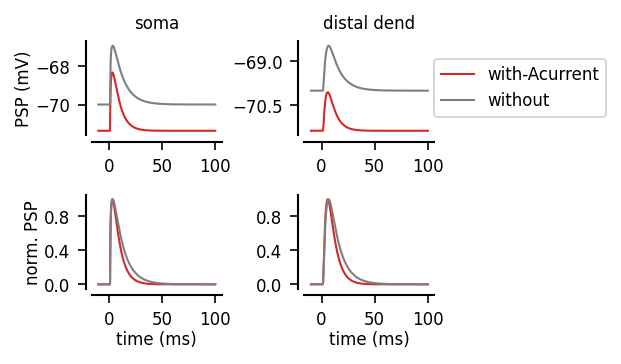

In [80]:
def norm(psp):
    return (psp-np.min(psp))/(np.max(psp)-np.min(psp))

iBranch = 0
fig, AX = pt.figure(axes=(2, 2))

for key, color in zip(['with-Acurrent', 'without'], ['tab:red', 'tab:grey']):
    
    # 1st element is distal dend
    AX[0][1].plot(T, VMs[key][iBranch][0], label=key, color=color)
    AX[1][1].plot(T, norm(VMs[key][iBranch][0]), color=color)
    # last element is soma
    AX[0][0].plot(T, VMs[key][iBranch][-1], color=color)
    AX[1][0].plot(T, norm(VMs[key][iBranch][-1]), color=color)
    
AX[0][0].set_title('soma')
AX[0][1].set_title('distal dend')
AX[0][1].legend(loc=(1.,0.2))
pt.set_plot(AX[0][0], ylabel='PSP (mV)')
pt.set_plot(AX[0][1])
pt.set_plot(AX[1][0], ylabel='norm. PSP', xlabel='time (ms)')
pt.set_plot(AX[1][1], xlabel='time (ms)')